In [7]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.svm import SVR
from fbprophet import Prophet


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
covid=pd.read_csv(r"../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
#Dropping column as SNo is of no use, and "Province/State" contains too many missing values
covid.drop(["SNo"],1,inplace=True)
#Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days
datewise.head()

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2020-01-22,555.0,28.0,17.0,0
2020-01-23,653.0,30.0,18.0,1
2020-01-24,941.0,36.0,26.0,2
2020-01-25,1438.0,39.0,42.0,3
2020-01-26,2118.0,52.0,56.0,4


In [10]:
model_scores=[]
mean_squared_error=[]
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
svr=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)
svr.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

prediction_valid_svm=svr.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

plt.figure(figsize=(11,6))
prediction_svr=svr.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svr,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

TypeError: 'list' object is not callable

Figure(720x432)


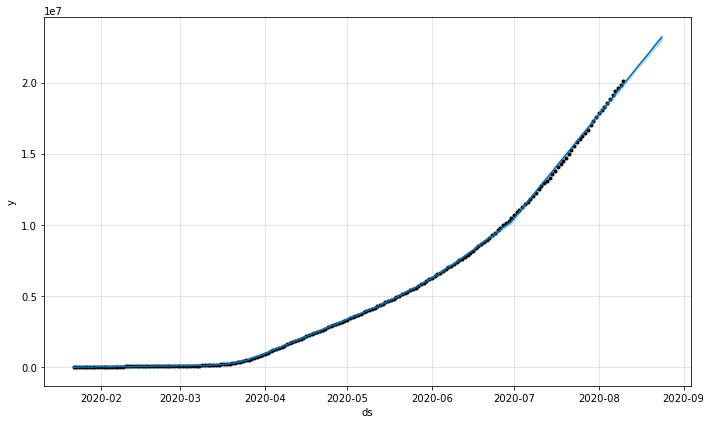

In [11]:
prophet_c=Prophet(interval_width=0.9,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])
prophet_c.fit(prophet_confirmed)
forecast_c=prophet_c.make_future_dataframe(periods=14)
forecast_confirmed=forecast_c.copy()
confirmed_forecast=prophet_c.predict(forecast_c)
# model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
# print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print(prophet_c.plot(confirmed_forecast))

In [ ]:
confirmed_forecast[149:155].to_csv('test.csv')

In [ ]:
confirmed_forecast[147:155]

In [ ]:
datewise

Figure(648x432)


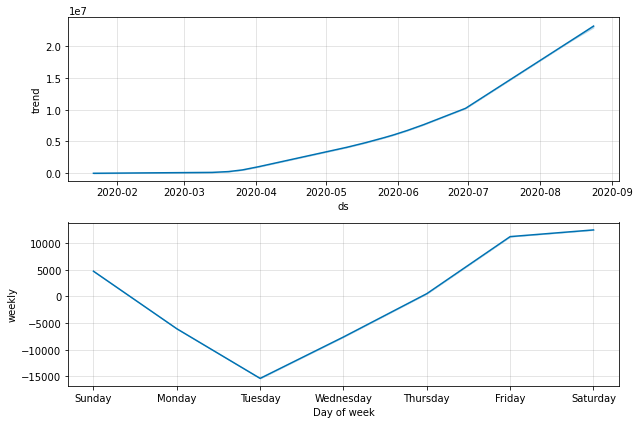

In [12]:
print(prophet_c.plot_components(confirmed_forecast))